#### Import necessary packages.  Note that Python 3.6 is used, as 3.7 is problematic for Tensorflow.


In [246]:
import re
import sys
import utils
from nltk.stem.porter import PorterStemmer
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import *
from keras.initializers import Constant
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf

#### Here are some functions for pre-processing.

In [363]:

def preprocess_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word


def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)


def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' smile ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' smile ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' love ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' wink ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' frown ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' cry ', tweet)
    return tweet


def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert characters to lower case
    tweet = tweet.lower()
    # Removes URLs
    tweet = re.sub(r'^https?:\/\/.*[\r\n]*', tweet, flags=re.MULTILINE)
    # Removes @handle 
    tweet=re.sub(r'\s([@#][\w_-]+ ', tweet)
    # Removes #hashtag 
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')
    # Replace emojis with semantic equivalent, from earlier function
    tweet = handle_emojis(tweet)
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    words = tweet.split()

    for word in words:
        word = preprocess_word(word)
        if is_valid_word(word):
            processed_tweet.append(word)
    return ' '.join(processed_tweet)

#### And here are some helper functions for plotting charts and rendering models' results.

In [364]:
def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'b', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'bo', label='Validation ' + metric_name)
    plt.legend()
    plt.show()
    
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

In [365]:
BATCH_SIZE=32
epoch_stop=10
NB_START_EPOCHS=10
MAX_SEQUENCE_LENGTH = 28
max_words = 10000
num_words=max_words
maxlen=28
embedding_dim = 100
lstm_out=196

#### First, I loaded the data.  It's not entirely clear what many of these fields meant, even after doing some searching, so I chose to keep sentiment, sentiment:confidence, and text.

In [366]:
df = pd.read_csv("~/dfe.csv", error_bad_lines=False, encoding='latin-1')
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,2014-12-12,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


#### I also dropped tweets that had a neutral sentiment value (3) or did not have a sentiment value, and output the new length of the dataset.

In [367]:
df=df.filter(['sentiment', 'sentiment:confidence', 'text'])
df = df[df['sentiment']!="3"]
df = df[df['sentiment']!='not_relevant']
len(df)

1642

#### I then examined the sentiment:confidence values.  A .333 would be the statistical equivalent to a guess, and human accuracy is apparently closer to .8, so I felt it made sense to drop some of the tweets.  I dropped the bottom 10% - ie. <.65443

In [368]:
df['sentiment:confidence'].describe()

count    1642.000000
mean        0.841509
std         0.176715
min         0.333900
25%         0.675900
50%         1.000000
75%         1.000000
max         1.000000
Name: sentiment:confidence, dtype: float64

In [369]:
df['sentiment:confidence'].quantile(.1)

0.65443

In [370]:
df=df[df['sentiment:confidence'] > 0.65443]
len(df)

1477

#### I also set converted the sentiment values from 1 and 5 to 0 and 1, and dropped the confidence column?

In [371]:
df.head()

,sentiment,sentiment:confidence,text
6,5,0.8468,Top 3 all @Apple #tablets. Damn right! http://...
7,5,0.6736,CNBCTV: #Apple's margins better than expected?...
10,1,1.0000,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...
13,5,1.0000,RT @peterpham: Bought my @AugustSmartLock at t...
14,1,1.0000,@apple Contact sync between Yosemite and iOS8 ...


In [372]:
df['sentiment'] = df['sentiment'].map(lambda x : 1 if int(x) >= 4 else 0)
df.head()

,sentiment,sentiment:confidence,text
6,1,0.8468,Top 3 all @Apple #tablets. Damn right! http://...
7,1,0.6736,CNBCTV: #Apple's margins better than expected?...
10,0,1.0000,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...
13,1,1.0000,RT @peterpham: Bought my @AugustSmartLock at t...
14,0,1.0000,@apple Contact sync between Yosemite and iOS8 ...


In [373]:
df = df[['sentiment', 'text']]
df.head()

,sentiment,text
6,1,Top 3 all @Apple #tablets. Damn right! http://...
7,1,CNBCTV: #Apple's margins better than expected?...
10,0,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...
13,1,RT @peterpham: Bought my @AugustSmartLock at t...
14,0,@apple Contact sync between Yosemite and iOS8 ...


#### With that done, I used the preprocessing functions to remove unwanted characters, URLs, usernames, and RT.  I also converted emojis to semantic equivalents.  I chose to remove all words that followed the @ symbol, as they pretty much all were Twitter handlenames of personal accounts or for Apple the company.

In [374]:
df.text = df.text.apply(preprocess_tweet)
df.reset_index(drop=True, inplace=True)
df.head(10)

TypeError: sub() missing 1 required positional argument: 'string'

#### Data is tokenized and shuffled.

In [289]:
tokenizer = Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(df['text'].values)
X = tokenizer.texts_to_sequences(df['text'].values)
word_index=tokenizer.word_index
X = pad_sequences(X, maxlen=maxlen)
Y = pd.get_dummies(df['sentiment']).values
Y=np.asarray(Y)


indices = np.arange(df.shape[0])
np.random.shuffle(indices)


#### Data split into test and training sets.  I used the common ratio 20/80 for my split.

In [290]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1181, 28) (1181, 2)
(296, 28) (296, 2)


#### The training data is further split into a validation set.

In [291]:
X_val = X_train[:200]
Y_val = Y_train[:200]

In [292]:
partial_X_train = X_train[200:]
partial_Y_train = Y_train[200:]

#### Glove word embeddings are loaded.

In [220]:
glove_dir = '/Users/lindsay_richman/glove.twitter.27B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.twitter.27B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


#### Embedding matrix is created.

In [293]:
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [294]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
start=time.time()
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 28, 100)           1000000   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 28, 100)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 196)               232848    
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 394       
Total params: 1,233,242
Trainable params: 233,242
Non-trainable params: 1,000,000
_________________________________________________________________
None


In [295]:
history = model.fit(partial_X_train, 
                    partial_Y_train, 
                    epochs = 10, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_val, Y_val),
                    shuffle=True)

Train on 981 samples, validate on 200 samples
Epoch 1/10
981/981 [==============================] - 5s 5ms/step - loss: 0.4906 - acc: 0.7564 - val_loss: 0.4805 - val_acc: 0.7800
Epoch 2/10
981/981 [==============================] - 1s 1ms/step - loss: 0.4002 - acc: 0.8277 - val_loss: 0.3723 - val_acc: 0.8300
Epoch 3/10
981/981 [==============================] - 1s 1ms/step - loss: 0.3758 - acc: 0.8461 - val_loss: 0.3342 - val_acc: 0.8600
Epoch 4/10
981/981 [==============================] - 1s 1ms/step - loss: 0.3523 - acc: 0.8491 - val_loss: 0.3000 - val_acc: 0.8650
Epoch 5/10
981/981 [==============================] - 1s 1ms/step - loss: 0.3548 - acc: 0.8512 - val_loss: 0.3427 - val_acc: 0.8350
Epoch 6/10
981/981 [==============================] - 1s 1ms/step - loss: 0.3309 - acc: 0.8685 - val_loss: 0.3028 - val_acc: 0.8700
Epoch 7/10
981/981 [==============================] - 1s 1ms/step - loss: 0.3329 - acc: 0.8614 - val_loss: 0.2946 - val_acc: 0.8550
Epoch 8/10
981/981 [==========

In [296]:
model_results = test_model(model, partial_X_train, partial_Y_train, X_val, Y_val, 6)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(model_results[1]*100))

200/200 [==============================] - 0s 301us/step
/n
Test accuracy of word embeddings model: 87.50%


In [297]:
history.history['acc'][-1].round(2)

0.86

In [298]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_val)):
    
    result = model.predict(X_val[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_val[x]):
        if np.argmax(Y_val[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_val[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1
print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 75.47169811320755 %
neg_acc 91.83673469387756 %


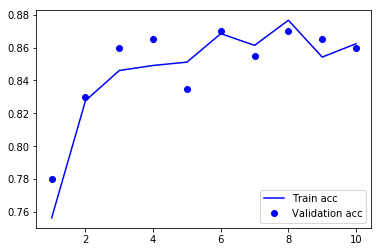

In [299]:
eval_metric(history, 'acc')

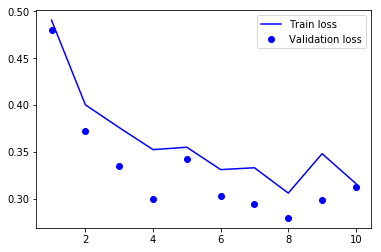

In [300]:
eval_metric(history, 'loss')

#### Adding a convolutional layer to improve performance.

In [301]:
model_glove = Sequential()
model_glove.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model_glove.add(Dropout(0.1))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(LSTM(lstm_out, dropout=0.1, recurrent_dropout=0.1))
model_glove.add(Dense(2, activation='softmax'))
model_glove.layers[0].set_weights([embedding_matrix])
model_glove.layers[0].trainable = False
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_glove.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 28, 100)           1000000   
_________________________________________________________________
dropout_18 (Dropout)         (None, 28, 100)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 24, 64)            32064     
_________________________________________________________________
lstm_30 (LSTM)               (None, 196)               204624    
_________________________________________________________________
dense_41 (Dense)             (None, 2)                 394       
Total params: 1,237,082
Trainable params: 237,082
Non-trainable params: 1,000,000
_________________________________________________________________


In [302]:
from keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
# define model
history2 = model_glove.fit(partial_X_train, 
                    partial_Y_train, 
                    epochs = 10, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_val, Y_val),
                    shuffle=True)


Train on 981 samples, validate on 200 samples
Epoch 1/10
981/981 [==============================] - 5s 5ms/step - loss: 0.5169 - acc: 0.7421 - val_loss: 0.4291 - val_acc: 0.8050
Epoch 2/10
981/981 [==============================] - 1s 1ms/step - loss: 0.3605 - acc: 0.8389 - val_loss: 0.3294 - val_acc: 0.8550
Epoch 3/10
981/981 [==============================] - 1s 1ms/step - loss: 0.3123 - acc: 0.8787 - val_loss: 0.3012 - val_acc: 0.8500
Epoch 4/10
981/981 [==============================] - 1s 1ms/step - loss: 0.2707 - acc: 0.8807 - val_loss: 0.2882 - val_acc: 0.8650
Epoch 5/10
981/981 [==============================] - 1s 1ms/step - loss: 0.2096 - acc: 0.9144 - val_loss: 0.2619 - val_acc: 0.8800
Epoch 6/10
981/981 [==============================] - 1s 1ms/step - loss: 0.1741 - acc: 0.9337 - val_loss: 0.2648 - val_acc: 0.8850
Epoch 7/10
981/981 [==============================] - 1s 1ms/step - loss: 0.1277 - acc: 0.9572 - val_loss: 0.2728 - val_acc: 0.9100
Epoch 8/10
981/981 [==========

In [303]:
glove_results = test_model(model_glove, partial_X_train, partial_Y_train, X_val, Y_val, 6)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(glove_results[1]*100))

200/200 [==============================] - 0s 289us/step
/n
Test accuracy of word embeddings model: 88.00%


In [304]:
history2.history['acc'][-1].round(2)

0.97

In [305]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_val)):
    
    result = model_glove.predict(X_val[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_val[x]):
        if np.argmax(Y_val[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_val[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1
print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 73.58490566037736 %
neg_acc 93.19727891156462 %


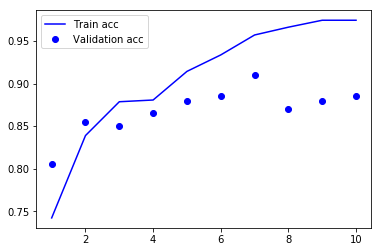

In [306]:
eval_metric(history2, 'acc')

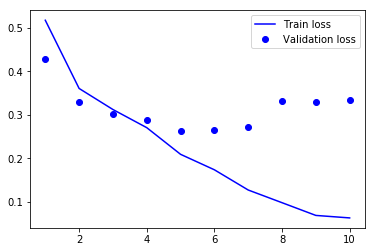

In [307]:
eval_metric(history2, 'loss')

#### Adjust a few paramaters and use sigmoid in the activation function.

In [308]:
model1 = Sequential()
model1.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model1.add(Dropout(0.2))
model1.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(300, kernel_initializer='uniform'))
model1.add(Activation('relu'))
model1.add(Dense(2, kernel_initializer='uniform'))
model1.add(Activation('sigmoid'))
model1.layers[0].set_weights([embedding_matrix])
model1.layers[0].trainable = False
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 28, 100)           1000000   
_________________________________________________________________
dropout_19 (Dropout)         (None, 28, 100)           0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 196)               232848    
_________________________________________________________________
dense_42 (Dense)             (None, 300)               59100     
_________________________________________________________________
activation_19 (Activation)   (None, 300)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 602       
_________________________________________________________________
activation_20 (Activation)   (None, 2)                 0         
Total para

In [309]:
history4 = model1.fit(partial_X_train, 
                    partial_Y_train, 
                    epochs = 10, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_val, Y_val),
                    shuffle=True)

Train on 981 samples, validate on 200 samples
Epoch 1/10
981/981 [==============================] - 5s 5ms/step - loss: 0.5504 - acc: 0.7503 - val_loss: 0.4879 - val_acc: 0.7350
Epoch 2/10
981/981 [==============================] - 1s 1ms/step - loss: 0.4071 - acc: 0.8196 - val_loss: 0.3406 - val_acc: 0.8650
Epoch 3/10
981/981 [==============================] - 1s 1ms/step - loss: 0.3382 - acc: 0.8542 - val_loss: 0.3146 - val_acc: 0.8750
Epoch 4/10
981/981 [==============================] - 1s 1ms/step - loss: 0.3273 - acc: 0.8603 - val_loss: 0.2633 - val_acc: 0.8650
Epoch 5/10
981/981 [==============================] - 1s 1ms/step - loss: 0.3051 - acc: 0.8700 - val_loss: 0.2761 - val_acc: 0.8975
Epoch 6/10
981/981 [==============================] - 1s 1ms/step - loss: 0.3013 - acc: 0.8736 - val_loss: 0.3700 - val_acc: 0.8625
Epoch 7/10
981/981 [==============================] - 1s 1ms/step - loss: 0.2873 - acc: 0.8818 - val_loss: 0.2889 - val_acc: 0.8800
Epoch 8/10
981/981 [==========

In [310]:
model1_results = test_model(model1, partial_X_train, partial_Y_train, X_val, Y_val, 6)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(model1_results[1]*100))

200/200 [==============================] - 0s 297us/step
/n
Test accuracy of word embeddings model: 90.50%


In [311]:
history4.history['acc'][-1].round(2)

0.9

#### Note: Looks like some overfitting.  Could probably stop at 7 epochs.

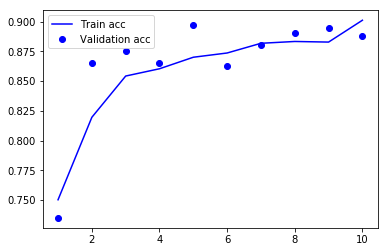

In [324]:
eval_metric(history4, 'acc')

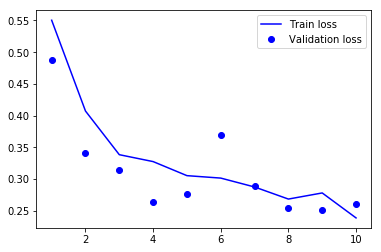

In [325]:
eval_metric(history4, 'loss')

In [314]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_val)):
    
    result = model1.predict(X_val[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_val[x]):
        if np.argmax(Y_val[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_val[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1
print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 79.24528301886792 %
neg_acc 94.5578231292517 %


#### Freezing and saving the graoh.

In [318]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [319]:
from keras import backend as K

# Create, compile and train model...

frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model1.outputs])

INFO:tensorflow:Froze 827 variables.
INFO:tensorflow:Converted 827 variables to const ops.


In [320]:
tf.train.write_graph(frozen_graph, "./saved", "model1.pb", as_text=False)

'./saved/model1.pb'

In [321]:
model2 = Sequential()
model2.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model2.add(Dropout(0.2))
model2.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(300, kernel_initializer='uniform'))
model2.add(Activation('relu'))
model2.add(Dense(2, kernel_initializer='uniform'))
model2.add(Activation('sigmoid'))
model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False
model2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 28, 100)           1000000   
_________________________________________________________________
dropout_20 (Dropout)         (None, 28, 100)           0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 196)               232848    
_________________________________________________________________
dense_44 (Dense)             (None, 300)               59100     
_________________________________________________________________
activation_21 (Activation)   (None, 300)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 2)                 602       
_________________________________________________________________
activation_22 (Activation)   (None, 2)                 0         
Total para

In [322]:
history5 = model2.fit(partial_X_train, 
                    partial_Y_train, 
                    epochs = 10, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_val, Y_val),
                    shuffle=True)

Train on 981 samples, validate on 200 samples
Epoch 1/10
981/981 [==============================] - 5s 5ms/step - loss: 0.4915 - acc: 0.7813 - val_loss: 0.4118 - val_acc: 0.8125
Epoch 2/10
981/981 [==============================] - 1s 1ms/step - loss: 0.3918 - acc: 0.8374 - val_loss: 0.3918 - val_acc: 0.8350
Epoch 3/10
981/981 [==============================] - 1s 1ms/step - loss: 0.3563 - acc: 0.8563 - val_loss: 0.3158 - val_acc: 0.8600
Epoch 4/10
981/981 [==============================] - 1s 1ms/step - loss: 0.3266 - acc: 0.8558 - val_loss: 0.3422 - val_acc: 0.8650
Epoch 5/10
981/981 [==============================] - 1s 1ms/step - loss: 0.3153 - acc: 0.8761 - val_loss: 0.2425 - val_acc: 0.8975
Epoch 6/10
981/981 [==============================] - 1s 1ms/step - loss: 0.2819 - acc: 0.8756 - val_loss: 0.2754 - val_acc: 0.8750
Epoch 7/10
981/981 [==============================] - 1s 1ms/step - loss: 0.2908 - acc: 0.8858 - val_loss: 0.2853 - val_acc: 0.8700
Epoch 8/10
981/981 [==========

In [323]:
model2_results = test_model(model2, partial_X_train, partial_Y_train, X_val, Y_val, 6)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(model2_results[1]*100))

200/200 [==============================] - 0s 303us/step
/n
Test accuracy of word embeddings model: 88.50%
